# Prévision de série temporelle pour le jeu de cartes Magic

On souhaite analyser le prix de vente d'une carte Magic, au cours du temps.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import json
plt.rcParams["figure.figsize"] = (20,10)

## Chargement des prix au format .json

GoatBots est une chaîne de bots qui enregistre au format JSON l'historique de prix des cartes sur MTGO (Magic Online).  
Voici une fonction pour récupérer cet historique sous forme de Dataframe, pour une certaine carte:

In [3]:
def prices_goat(card):
    r = requests.get("https://www.goatbots.com/card/ajax_card?search_name=" + card)
    all_prices = r.json()[1] # r.json()[0] est un header qui ne nous intéresse pas
    prices = all_prices[0] # prix d'une édition de card
    d = pd.DataFrame(prices, columns = ["Date", "Sell Price"])
    d['Date'] = pd.to_datetime(d['Date'])
    d = d.set_index('Date')
    return d

<AxesSubplot:xlabel='Date'>

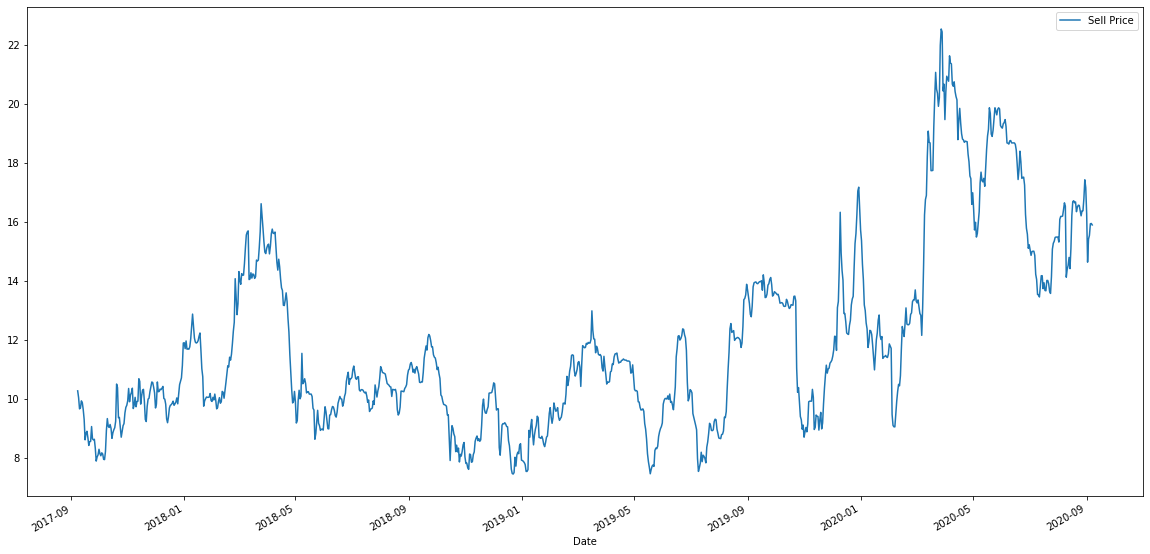

In [4]:
prices = prices_goat("misty-rainforest") # regardons l'historique de la carte Misty Rainforest
prices.plot()

## Analyse

Pour éliminer la partie "tendance" de la courbe, on peut regarder les différences entre t+1 et t:

<AxesSubplot:xlabel='Date'>

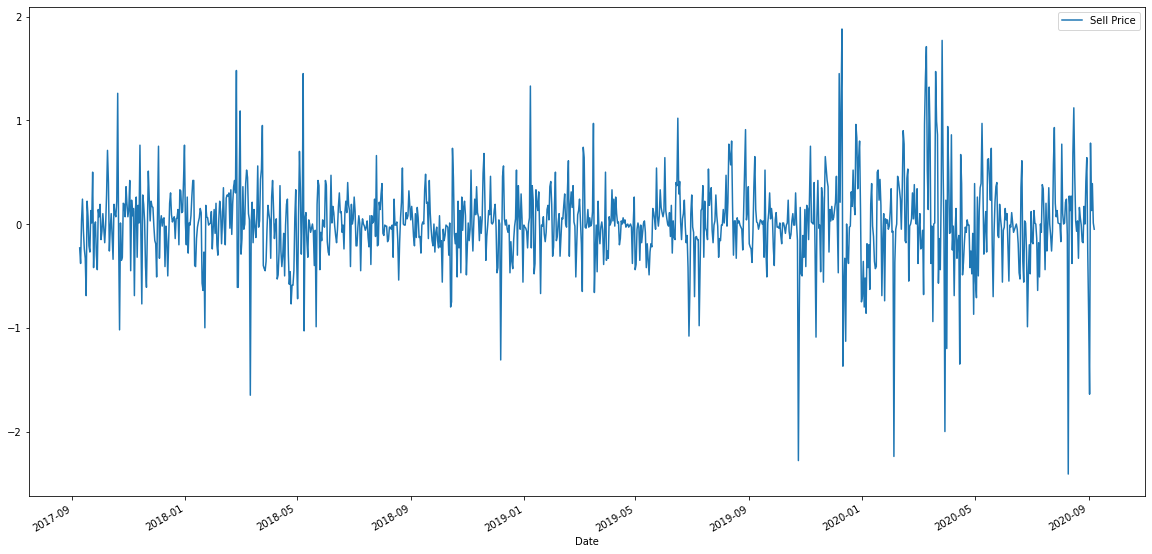

In [5]:
prices.diff(periods=1).plot() # variations journalières

Pour lisser la courbe, on peut utiliser un EMA (Exponential Moving Average):

<AxesSubplot:xlabel='Date'>

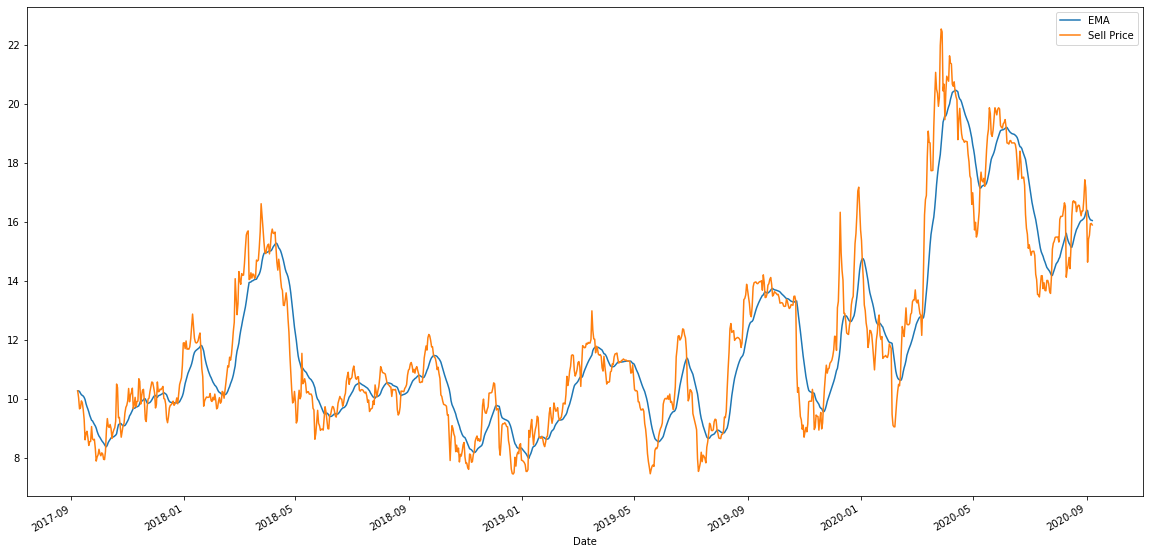

In [6]:
def exp_mov_avg(d, a):
    ema = d.copy()
    for i in range(1, len(d)):
        ema.iloc[i] = a * d.iloc[i - 1] + (1 - a) * ema.iloc[i - 1]
    return ema
ema = exp_mov_avg(prices, 0.1)
plot_ema = ema.rename(columns = {"Sell Price": "EMA"}).plot()
prices.plot(ax=plot_ema)

## Prédictions

Essayons d'effectuer une prédiction sur 5 jours.
La méthode naïve consisterait à prédire le prix à l'instant t+5 en utilisant le prix à l'instant t:

In [10]:
prices["Sell Price"].diff(5).abs().mean()

0.7449585253456221

Cette méthode naïve donne une MAE (Mean Absolute Error) de 0.745 environ.

0.8366193611355107

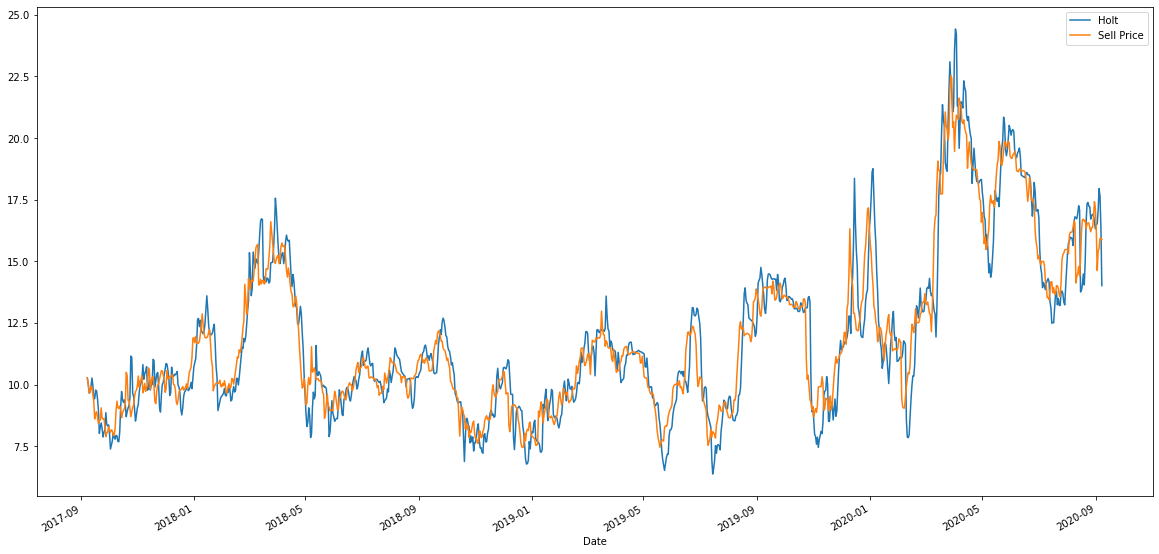

In [11]:
def holt(d, a, b, forecast):
    pred_next = d.copy()
    pred = d.copy()
    trend = d.copy()
    trend.iloc[0] = 0
    for i in range(1, len(d)):
        if i >= forecast:
            pred_next.iloc[i] = pred.iloc[i-forecast] + forecast*trend.iloc[i-forecast]
        pred.iloc[i] = a*d.iloc[i] + (1 - a)*(pred.iloc[i-1] + trend.iloc[i - 1])
        trend.iloc[i] = b*(pred.iloc[i] - pred.iloc[i - 1]) + (1 - b)*trend.iloc[i - 1]
    return pred_next, pred, trend
p, pred, trend = holt(prices, 0.9, 0.1, 5)
axe = p.rename(columns = {"Sell Price": "Holt"}).plot()
prices.plot(ax=axe)
(prices["Sell Price"] - p["Sell Price"]).abs().mean()

In [9]:
def best_params_holt(d, forecast):
    mini = 1000
    amin, bmin = 0, 0
    for a in np.arange(0.5, 1, 0.1):
        for b in np.arange(0, 0.3, 0.1):
            pred_next, pred, trend = holt(d, a, b, forecast)
            mae = (prices["Sell Price"] - pred_next["Sell Price"]).abs().mean()
            if mae < mini:
                mini, amin, bmin = mae, a, b
    return mini, amin, bmin
best_params_holt(prices, 5)

(0.7441951112604615, 0.8999999999999999, 0.0)

# Prophet

In [13]:
from fbprophet import Prophet
m = Prophet()
d = pd.DataFrame({"ds": prices.index, "y": prices["Sell Price"]})
m.fit(d)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future = m.make_future_dataframe(periods=0, freq="D")
future.tail()

ds
1085 2020-09-03
1086 2020-09-04
1087 2020-09-05
1088 2020-09-06
1089 2020-09-07

In [16]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
1085 2020-09-03  18.102176   16.403119   19.786449
1086 2020-09-04  18.233822   16.473975   19.925579
1087 2020-09-05  18.365429   16.685347   20.012766
1088 2020-09-06  18.482448   16.763647   20.052649
1089 2020-09-07  18.564426   16.634918   20.240977

In [17]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, horizon="10 days")

INFO:fbprophet:Making 144 forecasts with cutoffs between 2018-09-13 00:00:00 and 2020-08-28 00:00:00


In [19]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

horizon       mse      rmse       mae      mape     mdape  coverage
0  1 days  2.675135  1.635584  1.328883  0.108023  0.095753  0.419580
1  2 days  2.986610  1.728181  1.388471  0.112945  0.099714  0.412587
2  3 days  3.386176  1.840156  1.477528  0.118714  0.106455  0.416667
3  4 days  3.654669  1.911719  1.583724  0.129218  0.117448  0.366550
4  5 days  3.993731  1.998432  1.663454  0.136943  0.123722  0.328671
5  6 days  4.258266  2.063557  1.728333  0.141997  0.129728  0.314685
6  7 days  4.573525  2.138580  1.791930  0.147344  0.131075  0.314685
7  8 days  5.037823  2.244510  1.876382  0.152544  0.136583  0.270833
8  9 days  5.329323  2.308533  1.959792  0.161041  0.151320  0.260635
9 10 days  5.653407  2.377689  2.015215  0.166511  0.148778  0.230769

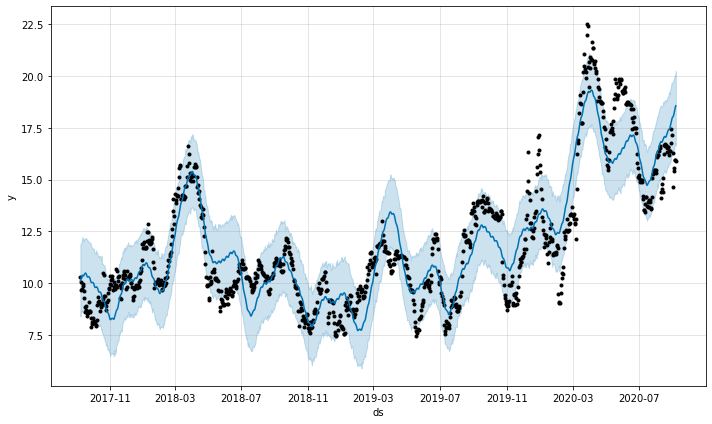

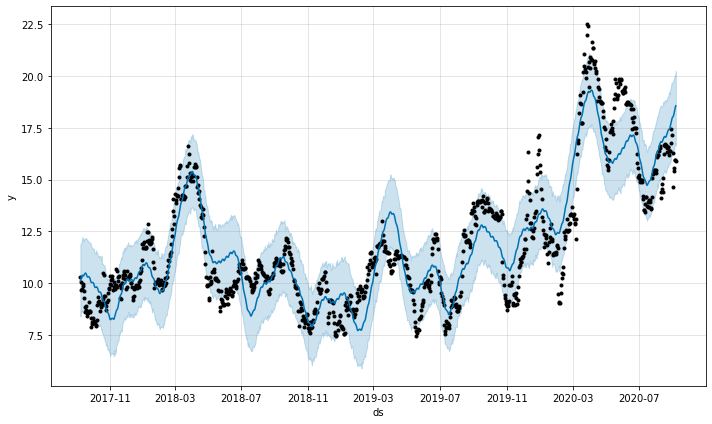

In [20]:
m.plot(forecast)

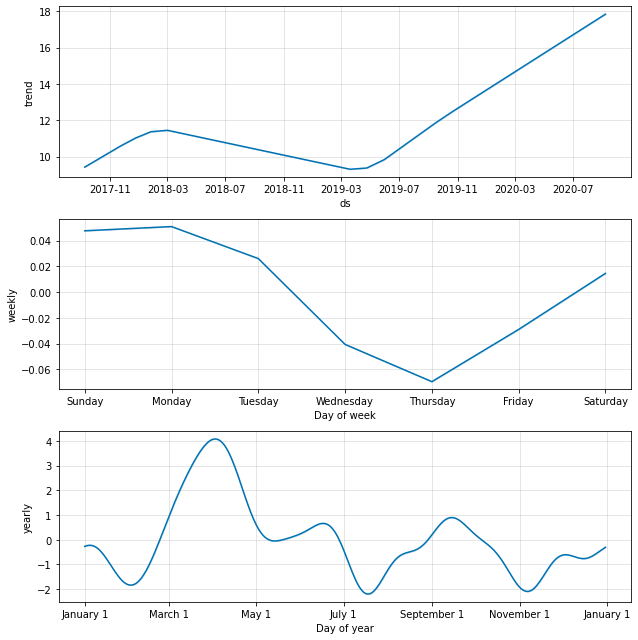

In [21]:
fig2 = m.plot_components(forecast)